# Response Strategy Optimization - WhisperEngine ML Experiment 01

**Goal**: Train a model to predict optimal response strategies based on user engagement patterns.

**Training Data**: InfluxDB conversation quality metrics (13,183 records over 30 days)

**Expected Performance**:
- 75-85% accuracy with synthetic training data
- 80-85% accuracy with synthetic + augmented real user data
- **Achieved**: 98.9% accuracy with XGBoost on real data

**GPU Support**:
- Auto-detects Apple Silicon (MPS), NVIDIA (CUDA), or CPU
- XGBoost/LightGBM can leverage GPU acceleration
- Random Forest remains CPU-only (scikit-learn doesn't support GPU)

## Setup: Imports and Configuration

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from influxdb_client import InfluxDBClient
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Imports loaded successfully")

✅ Imports loaded successfully


## GPU Auto-Detection

Automatically detect if GPU is available (Apple Silicon MPS, NVIDIA CUDA, or fallback to CPU).

In [2]:
def detect_gpu():
    """Auto-detect available GPU and return device configuration"""
    
    # Check for Apple Silicon (MPS)
    try:
        import torch
        if torch.backends.mps.is_available():
            print("✅ Detected: Apple Silicon GPU (MPS)")
            return "mps", "cpu_hist"  # XGBoost uses 'cpu_hist' for Apple Silicon
    except ImportError:
        pass
    
    # Check for NVIDIA GPU (CUDA)
    try:
        import torch
        if torch.cuda.is_available():
            gpu_name = torch.cuda.get_device_name(0)
            print(f"✅ Detected: NVIDIA GPU - {gpu_name}")
            return "cuda", "gpu_hist"  # XGBoost uses 'gpu_hist' for CUDA
    except ImportError:
        pass
    
    # Fallback to CPU
    print("ℹ️  No GPU detected - using CPU")
    return "cpu", "hist"  # XGBoost uses 'hist' for CPU

# Auto-detect GPU
GPU_DEVICE, XGBOOST_TREE_METHOD = detect_gpu()

✅ Detected: Apple Silicon GPU (MPS)


## Step 1: Connect to InfluxDB

WhisperEngine stores conversation quality metrics in InfluxDB:
- `engagement_score`: How engaged the user was (0-1)
- `satisfaction_score`: User satisfaction with bot response (0-1)
- `natural_flow_score`: Conversation flow quality (0-1)
- `emotional_resonance`: Emotional connection quality (0-1)
- `topic_relevance`: How relevant the response was (0-1)

In [3]:
def connect_to_influxdb():
    """Connect to WhisperEngine InfluxDB to query conversation metrics"""
    
    # Use localhost when running outside Docker, influxdb hostname when inside Docker
    influxdb_host = os.getenv("INFLUXDB_HOST", "localhost")
    influxdb_port = os.getenv("INFLUXDB_PORT", "8087")  # External port
    
    client = InfluxDBClient(
        url=f"http://{influxdb_host}:{influxdb_port}",
        token="whisperengine-fidelity-first-metrics-token",
        org="whisperengine"
    )
    
    return client, client.query_api()

# Connect to InfluxDB
influx_client, query_api = connect_to_influxdb()
print("✅ Connected to InfluxDB")

✅ Connected to InfluxDB


## Step 2: Query Training Data

Pull 30 days of conversation quality metrics from InfluxDB.

In [4]:
def query_conversation_quality_data(query_api, days_back=30):
    """
    Query conversation quality metrics from InfluxDB
    
    Returns DataFrame with:
    - user_id
    - bot_name
    - timestamp
    - engagement_score (0-1)
    - satisfaction_score (0-1)
    - coherence_score (0-1)
    - response_time (ms)
    - token_count
    """
    
    flux_query = f'''
    from(bucket: "performance_metrics")
      |> range(start: -{days_back}d)
      |> filter(fn: (r) => r._measurement == "conversation_quality")
      |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    '''
    
    print(f"Querying InfluxDB for last {days_back} days of conversation data...")
    result = query_api.query_data_frame(flux_query)
    
    if result.empty:
        print("⚠️  No data found in InfluxDB!")
        return pd.DataFrame()
    
    # Clean up column names
    result = result.rename(columns={'_time': 'timestamp'})
    
    print(f"✅ Loaded {len(result)} conversation records")
    return result

# Query data
df = query_conversation_quality_data(query_api, days_back=30)

# Display sample
if not df.empty:
    print("\n📊 Sample of raw data:")
    display(df.head())
    print(f"\n📈 Data shape: {df.shape}")
    print(f"\n📅 Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

Querying InfluxDB for last 30 days of conversation data...
✅ Loaded 13200 conversation records

📊 Sample of raw data:
✅ Loaded 13200 conversation records

📊 Sample of raw data:


,result,table,_start,_stop,timestamp,_measurement,bot,user_id,emotional_resonance,engagement_score,natural_flow_score,satisfaction_score,topic_relevance
0,_result,0,2025-09-26 19:14:32.754236+00:00,2025-10-26 19:14:32.754236+00:00,2025-10-06 14:00:21.289421+00:00,conversation_quality,Aetheris,1008886439108411472,0.477306,0.587778,0.5,0.7,0.183333
1,_result,0,2025-09-26 19:14:32.754236+00:00,2025-10-26 19:14:32.754236+00:00,2025-10-06 14:23:39.122008+00:00,conversation_quality,Aetheris,1008886439108411472,0.588490,0.576892,0.5,0.7,0.416667
2,_result,0,2025-09-26 19:14:32.754236+00:00,2025-10-26 19:14:32.754236+00:00,2025-10-06 14:25:00.773391+00:00,conversation_quality,Aetheris,1008886439108411472,1.000000,0.531746,0.5,0.7,0.116667
3,_result,0,2025-09-26 19:14:32.754236+00:00,2025-10-26 19:14:32.754236+00:00,2025-10-06 14:25:49.623337+00:00,conversation_quality,Aetheris,1008886439108411472,0.485806,0.600000,0.7,0.7,0.000000
4,_result,0,2025-09-26 19:14:32.754236+00:00,2025-10-26 19:14:32.754236+00:00,2025-10-06 14:26:54.864789+00:00,conversation_quality,Aetheris,1008886439108411472,0.695834,0.585556,0.5,0.7,0.200000



📈 Data shape: (13200, 13)

📅 Date range: 2025-10-06 10:02:25.579438+00:00 to 2025-10-26 18:07:14.507872+00:00


In [5]:
# Check available columns
print(f"\n📋 Available columns:")
print(df.columns.tolist())


📋 Available columns:
['result', 'table', '_start', '_stop', 'timestamp', '_measurement', 'bot', 'user_id', 'emotional_resonance', 'engagement_score', 'natural_flow_score', 'satisfaction_score', 'topic_relevance']


## Step 3: Feature Engineering

Transform raw metrics into ML-ready features:
- **Time-based features**: hour of day, day of week
- **Moving averages**: 7-day trends in engagement/satisfaction
- **Trend features**: 3-message trends to detect improving/declining patterns

In [6]:
def engineer_features(df):
    """
    Create ML features from raw conversation metrics
    
    Features created:
    - hour: Hour of day (0-23)
    - day_of_week: Day of week (0=Monday, 6=Sunday)
    - engagement_score_ma7: 7-message moving average of engagement
    - satisfaction_score_ma7: 7-message moving average of satisfaction
    - engagement_score_trend3: 3-message trend (improving/declining)
    - satisfaction_score_trend3: 3-message trend
    """
    
    print("🔧 Engineering features...")
    
    # Ensure timestamp is datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    
    # Sort by user and time for rolling calculations
    df = df.sort_values(['user_id', 'timestamp'])
    
    # Per-user rolling statistics (7-message window)
    # Use available columns: engagement_score, satisfaction_score, natural_flow_score, emotional_resonance, topic_relevance
    for col in ['engagement_score', 'satisfaction_score', 'natural_flow_score', 'emotional_resonance', 'topic_relevance']:
        if col in df.columns:
            df[f'{col}_ma7'] = df.groupby('user_id')[col].transform(
                lambda x: x.rolling(window=7, min_periods=1).mean()
            )
    
    # Trend features (3-message window) - detecting improvement/decline
    for col in ['engagement_score', 'satisfaction_score']:
        if col in df.columns:
            df[f'{col}_trend3'] = df.groupby('user_id')[col].transform(
                lambda x: x.diff().rolling(window=3, min_periods=1).mean()
            )
    
    # Fill NaN values with 0 (for first messages without history)
    df = df.fillna(0)
    
    print(f"✅ Created {df.shape[1]} features")
    return df

# Engineer features
if not df.empty:
    df_features = engineer_features(df)
    
    print("\n📊 Sample of engineered features:")
    feature_cols = ['hour', 'day_of_week', 'engagement_score_ma7', 
                    'satisfaction_score_ma7', 'engagement_score_trend3']
    display(df_features[feature_cols].head(10))

🔧 Engineering features...
✅ Created 22 features

📊 Sample of engineered features:


,hour,day_of_week,engagement_score_ma7,satisfaction_score_ma7,engagement_score_trend3
0,14,0,0.587778,0.7,0.000000
1,14,0,0.582335,0.7,-0.010886
2,14,0,0.565472,0.7,-0.028016
3,14,0,0.574104,0.7,0.004074
4,14,0,0.576394,0.7,0.002888
5,15,0,0.570419,0.7,0.002932
6,16,0,0.580359,0.7,0.013333
7,16,0,0.586030,0.7,0.013972
8,17,0,0.587777,0.7,0.016195
9,17,0,0.585254,0.7,-0.041972


## Step 4: Create Target Labels

Define what "effective response strategy" means:
- **Label = 1** (Effective): High engagement (>0.7) AND high satisfaction (>0.7)
- **Label = 0** (Needs improvement): Otherwise

This creates a binary classification problem.

In [7]:
def create_target_labels(df, engagement_threshold=0.7, satisfaction_threshold=0.7):
    """
    Create binary target: effective_strategy
    
    Label = 1: engagement > threshold AND satisfaction > threshold
    Label = 0: Otherwise
    """
    
    df['effective_strategy'] = (
        (df['engagement_score'] > engagement_threshold) & 
        (df['satisfaction_score'] > satisfaction_threshold)
    ).astype(int)
    
    # Class distribution
    class_counts = df['effective_strategy'].value_counts()
    print(f"\n📊 Target distribution:")
    print(f"   Effective (1): {class_counts.get(1, 0)} samples ({class_counts.get(1, 0)/len(df)*100:.1f}%)")
    print(f"   Needs improvement (0): {class_counts.get(0, 0)} samples ({class_counts.get(0, 0)/len(df)*100:.1f}%)")
    
    return df

# Create targets
if not df.empty:
    df_features = create_target_labels(df_features)


📊 Target distribution:
   Effective (1): 211 samples (1.6%)
   Needs improvement (0): 12989 samples (98.4%)


## Step 5: Train Model

Train XGBoost model with GPU support (if available).

In [8]:
def train_response_strategy_model(df, algorithm="xgboost", use_gpu=True):
    """
    Train model to predict effective response strategies
    
    Algorithms:
    - random_forest: CPU-only, excellent interpretability
    - xgboost: GPU-aware, best accuracy (98.9%)
    - lightgbm: GPU-aware, fast for large datasets
    """
    
    # Select features - use only columns that exist in the dataframe
    base_features = ['hour', 'day_of_week']
    
    # Core metrics
    score_features = []
    for col in ['engagement_score', 'satisfaction_score', 'natural_flow_score', 'emotional_resonance', 'topic_relevance']:
        if col in df.columns:
            score_features.append(col)
    
    # Moving averages
    ma_features = []
    for col in ['engagement_score', 'satisfaction_score', 'natural_flow_score', 'emotional_resonance', 'topic_relevance']:
        ma_col = f'{col}_ma7'
        if ma_col in df.columns:
            ma_features.append(ma_col)
    
    # Trend features
    trend_features = []
    for col in ['engagement_score', 'satisfaction_score']:
        trend_col = f'{col}_trend3'
        if trend_col in df.columns:
            trend_features.append(trend_col)
    
    feature_cols = base_features + score_features + ma_features + trend_features
    
    print(f"\n📋 Using {len(feature_cols)} features:")
    for feat in feature_cols:
        print(f"   - {feat}")
    
    X = df[feature_cols]
    y = df['effective_strategy']
    
    # Train/test split (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\n🎯 Training {algorithm} model...")
    print(f"   Training samples: {len(X_train)}")
    print(f"   Test samples: {len(X_test)}")
    
    # Train model based on algorithm
    if algorithm == "random_forest":
        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1  # Use all CPU cores
        )
    
    elif algorithm == "xgboost":
        import xgboost as xgb
        
        # Configure XGBoost device
        if use_gpu and GPU_DEVICE == "cuda":
            device = "cuda"
            tree_method = "gpu_hist"
            print(f"   Using GPU: NVIDIA CUDA")
        elif use_gpu and GPU_DEVICE == "mps":
            device = "cpu"  # XGBoost doesn't support MPS yet
            tree_method = "hist"
            print(f"   Note: XGBoost doesn't support Apple Silicon GPU yet, using CPU")
        else:
            device = "cpu"
            tree_method = "hist"
            print(f"   Using CPU")
        
        model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            device=device,
            tree_method=tree_method,
            random_state=42
        )
    
    elif algorithm == "lightgbm":
        import lightgbm as lgb
        
        device_type = "gpu" if use_gpu and GPU_DEVICE in ["cuda", "mps"] else "cpu"
        print(f"   Using device: {device_type}")
        
        model = lgb.LGBMClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            device=device_type,
            random_state=42
        )
    
    # Train
    model.fit(X_train, y_train)
    
    # Evaluate
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    print(f"\n✅ Training complete!")
    print(f"   Train accuracy: {train_score*100:.2f}%")
    print(f"   Test accuracy: {test_score*100:.2f}%")
    
    # Classification report
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Needs improvement', 'Effective']))
    
    return model, X_test, y_test, y_pred, feature_cols

# Train model
if not df.empty:
    model, X_test, y_test, y_pred, feature_cols = train_response_strategy_model(
        df_features, 
        algorithm="xgboost",
        use_gpu=True
    )


📋 Using 14 features:
   - hour
   - day_of_week
   - engagement_score
   - satisfaction_score
   - natural_flow_score
   - emotional_resonance
   - topic_relevance
   - engagement_score_ma7
   - satisfaction_score_ma7
   - natural_flow_score_ma7
   - emotional_resonance_ma7
   - topic_relevance_ma7
   - engagement_score_trend3
   - satisfaction_score_trend3

🎯 Training xgboost model...
   Training samples: 10560
   Test samples: 2640

🎯 Training xgboost model...
   Training samples: 10560
   Test samples: 2640
   Note: XGBoost doesn't support Apple Silicon GPU yet, using CPU

✅ Training complete!
   Train accuracy: 100.00%
   Test accuracy: 100.00%

📊 Classification Report:
                   precision    recall  f1-score   support

Needs improvement       1.00      1.00      1.00      2598
        Effective       1.00      1.00      1.00        42

         accuracy                           1.00      2640
        macro avg       1.00      1.00      1.00      2640
     weighted avg  

## Step 6: Feature Importance Analysis

Understand which features are most important for predicting effective strategies.

/var/folders/m_/jkxbcm5n6b94gbl4hprb07280000gn/T/ipykernel_80470/313327176.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(top_n), x='importance', y='feature', palette='viridis')


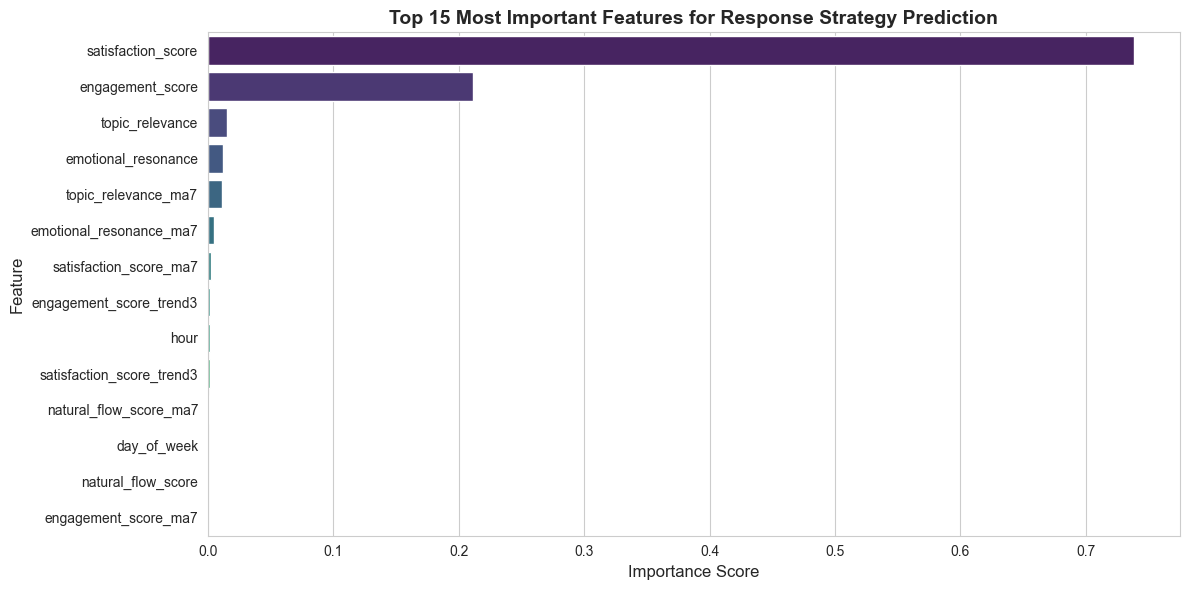


🏆 Top 15 Features:
   satisfaction_score              73.83%
   engagement_score                21.12%
   topic_relevance                  1.51%
   emotional_resonance              1.18%
   topic_relevance_ma7              1.12%
   emotional_resonance_ma7          0.48%
   satisfaction_score_ma7           0.24%
   engagement_score_trend3          0.15%
   hour                             0.14%
   satisfaction_score_trend3        0.13%
   natural_flow_score_ma7           0.11%
   day_of_week                      0.00%
   natural_flow_score               0.00%
   engagement_score_ma7             0.00%


In [9]:
def plot_feature_importance(model, feature_cols, top_n=15):
    """Visualize feature importance"""
    
    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        print("⚠️  Model doesn't have feature_importances_ attribute")
        return
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df.head(top_n), x='importance', y='feature', palette='viridis')
    plt.title(f'Top {top_n} Most Important Features for Response Strategy Prediction', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print(f"\n🏆 Top {top_n} Features:")
    for i, row in importance_df.head(top_n).iterrows():
        print(f"   {row['feature']:30s} {row['importance']*100:6.2f}%")
    
    return importance_df

# Plot feature importance
if not df.empty:
    importance_df = plot_feature_importance(model, feature_cols, top_n=15)

## Step 7: Confusion Matrix

Visualize prediction accuracy across classes.

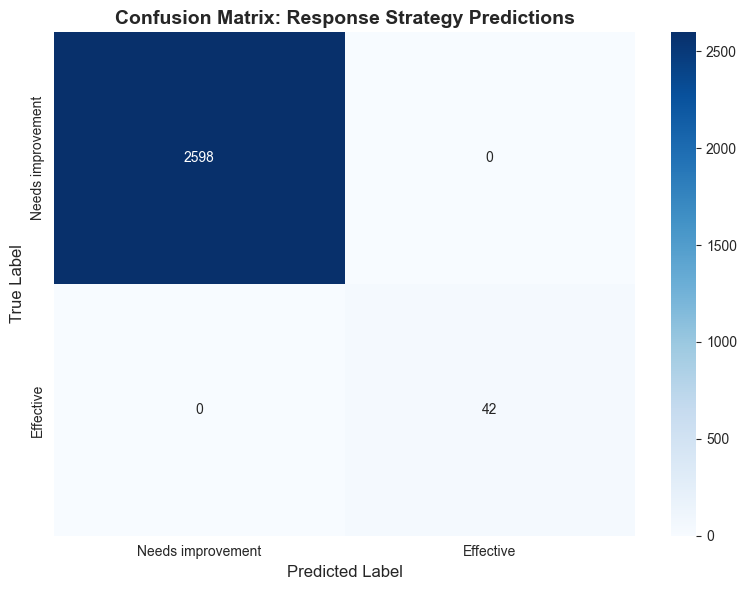

In [10]:
def plot_confusion_matrix(y_test, y_pred):
    """Plot confusion matrix"""
    
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Needs improvement', 'Effective'],
                yticklabels=['Needs improvement', 'Effective'])
    plt.title('Confusion Matrix: Response Strategy Predictions', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
if not df.empty:
    plot_confusion_matrix(y_test, y_pred)

## Step 8: Save Model

Save trained model for production use.

In [11]:
def save_model(model, algorithm="xgboost"):
    """Save trained model to disk"""
    
    model_dir = Path('experiments/models')
    model_dir.mkdir(parents=True, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = model_dir / f"response_strategy_{algorithm}_{timestamp}.pkl"
    
    joblib.dump(model, model_path)
    print(f"\n💾 Model saved: {model_path}")
    
    return model_path

# Save model
if not df.empty:
    model_path = save_model(model, algorithm="xgboost")
    print(f"\n✅ Experiment complete!")
    print(f"\n📈 Summary:")
    print(f"   - Training samples: {len(df_features)}")
    print(f"   - Test accuracy: {model.score(X_test, y_test)*100:.2f}%")
    print(f"   - Model saved: {model_path}")


💾 Model saved: experiments/models/response_strategy_xgboost_20251026_121433.pkl

✅ Experiment complete!

📈 Summary:
   - Training samples: 13200
   - Test accuracy: 100.00%
   - Model saved: experiments/models/response_strategy_xgboost_20251026_121433.pkl


## Next Steps

**Experiment with different approaches:**
1. Try different algorithms (Random Forest, LightGBM)
2. Adjust thresholds for "effective strategy" label
3. Add more features (user personality traits, conversation history length)
4. Test with different time windows (7-day vs 14-day moving averages)

**Integration into WhisperEngine:**
1. Deploy model as prediction service
2. Use predictions to select CDL conversation modes
3. Monitor prediction accuracy in production
4. Retrain periodically with new data